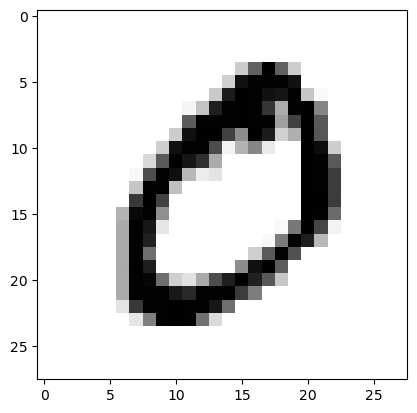

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import idx2numpy

training_images_data ='Data/train-images.idx3-ubyte'
training_labels_data = 'Data/train-labels.idx1-ubyte'
test_images_data = 'Data/t10k-images.idx3-ubyte'
test_labels_data = 'Data/t10k-labels.idx1-ubyte'


def read(x): return idx2numpy.convert_from_file(x)

training_images = read(training_images_data)
training_labels = read(training_labels_data)
test_images = read(test_images_data)
test_labels = read(test_labels_data)

plt.imshow(training_images[1], cmap=plt.cm.binary)

## KNN for MNIST data set 60000

In [124]:
def PrepData(data):
    return_data = []
    
    for image in data:
        image_flatten = image.flatten()
        image = image_flatten/max(image_flatten)
        return_data.append(image)
        
    return np.array(return_data)

def EuclidianDistance(x1, x2):
    distance = np.sqrt(np.sum((x1 - x2)**2))
    return distance

def KnnPredict(images_train, labels_train, images_test, k):
    predictions = []
    count = 0
    
    for test_point in images_test:
        
        # Calculating distance from test_point to all images
        distances = [EuclidianDistance(test_point, train_point) for train_point in images_train]
        
        # Getting the 'k' closest images
        indice_NN = np.argsort(distances)[:k]
        
        # Getting label
        label_NN = labels_train[indice_NN]
        
        # Majority voting of 'k' predictions
        unique, counts = np.unique(label_NN, return_counts = True)
        best_prediction = unique[np.argmax(counts)]
        
        # Append prediction for image
        predictions.append(best_prediction)
        
        count += 1
        if count % int(0.2*len(images_test)) ==0:
            print("At image: " + str(count))
            
    return np.array(predictions)

lim  = 5000

X_train = PrepData(training_images.copy()[:lim])
X_test = PrepData(test_images.copy()[:lim])

Y_test = test_labels[:lim]
Y_train = training_labels[:lim]

predicted_test = KnnPredict(X_train, Y_train, X_test, k=5)

print("KNN - no preprocessing:", sum(Y_test == predicted_test)/lim)

At image: 1000
At image: 2000
At image: 3000
At image: 4000
At image: 5000
KNN - no preprocessing: 0.9062


## Simple ANN for MNIST data set

In [125]:
from sklearn.preprocessing import OneHotEncoder

# Activation functions and derivatives
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

# Initialize weights and biases
def initialize_weights(input_size, hidden_size, output_size):
    np.random.seed(42)
    W1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros((1, output_size))
    return W1, b1, W2, b2

# Forward pass
def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    cache = (Z1, A1, Z2, A2)
    return A2, cache

# Backward pass
def backward_propagation(X, y, cache, W1, W2):
    Z1, A1, Z2, A2 = cache
    m = X.shape[0]

    dZ2 = A2 - y
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dZ1 = np.dot(dZ2, W2.T) * sigmoid_derivative(Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    return dW1, db1, dW2, db2

def train(X_train, y_train, input_size, hidden_size, output_size, learning_rate, epochs):
    # Initialize weights and biases
    W1, b1, W2, b2 = initialize_weights(input_size, hidden_size, output_size)

    for epoch in range(epochs):
        # Forward propagation
        A2, cache = forward_propagation(X_train, W1, b1, W2, b2)

        # Compute loss (mean squared error)
        loss = np.mean((A2 - y_train) ** 2)

        # Backward propagation
        dW1, db1, dW2, db2 = backward_propagation(X_train, y_train, cache, W1, W2)

        # Update weights and biases
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

    return W1, b1, W2, b2

def predict(X, W1, b1, W2, b2):
    A2, _ = forward_propagation(X, W1, b1, W2, b2)
    return np.argmax(A2, axis=1)

def accuracy(y_true, y_pred):
    y_true_labels = np.argmax(y_true, axis=1)
    return np.mean(y_true_labels == y_pred)


lim  = 5000

X_train = PrepData(training_images.copy()[:lim])
X_test = PrepData(test_images.copy()[:lim])

y_test = np.array(test_labels[:lim])
y_train = np.array(training_labels[:lim])

# One-hot encode y_train (if not already done)
encoder = OneHotEncoder(sparse=False)
Y_train = encoder.fit_transform(y_train.reshape(-1, 1))
Y_test = encoder.fit_transform(y_test.reshape(-1, 1))

# Define hyperparameters
input_size = 784      # 28x28 flattened images
hidden_size = 64      # Number of neurons in the hidden layer
output_size = 10      # 10 classes for digits 0-9
learning_rate = 0.1
epochs = 1000

# Train the neural network
W1, b1, W2, b2 = train(X_train, Y_train, input_size, hidden_size, output_size, learning_rate, epochs)

# Predict on test data
y_pred = predict(X_test, W1, b1, W2, b2)

# Evaluate accuracy
test_accuracy = accuracy(Y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Software/users/modules/9/software/anaconda3/2024.02/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 0, Loss: 0.24950662854643696
Epoch 100, Loss: 0.08960072479200419
Epoch 200, Loss: 0.08630893923297041
Epoch 300, Loss: 0.07286437162639342
Epoch 400, Loss: 0.05913109902532594
Epoch 500, Loss: 0.04947219564950922
Epoch 600, Loss: 0.04234884866764499
Epoch 700, Loss: 0.03687599440576328
Epoch 800, Loss: 0.03267711138723616
Epoch 900, Loss: 0.029383042657001198
Test Accuracy: 82.54%


## PCA test and result 
- PCA destroys important information on the image

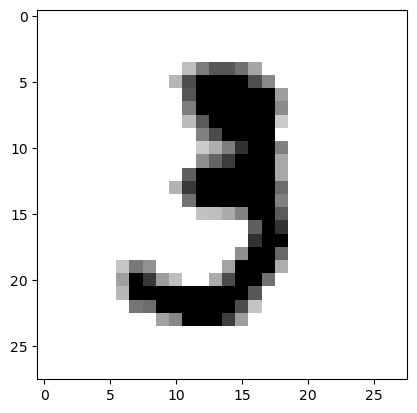

In [126]:
# Example data
X = training_images[10]/255

# Apply PCA keeping 3 highest variance
pca = decomposition.PCA(n_components = 4)

X_reduced = pca.fit_transform(X)

# Inverse transform to reconstruct
X_reconstructed = pca.inverse_transform(X_reduced)

# Cleaning (Define lines better)
X_reconstructed[X_reconstructed < 0.2] = 0
X_reconstructed[X_reconstructed > 0.8] = 1

# Image reconstructed data
plt.imshow(X_reconstructed, cmap=plt.cm.binary)

#print("Original Data:\n", X)
#print("Reduced Data:\n", X_reduced)
#print("Reconstructed Data:\n", X_reconstructed)

## Trying KNN with PCA 

In [95]:
lim  = 2000

# Apply PCA keeping 3 highest variance
pca = decomposition.PCA(n_components = 3)

# PCA reducing for first 3 axes
X_reduced = [pca.fit_transform(images) for images in training_images.copy()[:lim]]

# Inverse transform to reconstruct
X_reconstructed = pca.inverse_transform(X_reduced)

# Cleaning (Define lines better)
X_reconstructed[X_reconstructed < 0.2] = 0
X_reconstructed[X_reconstructed > 0.8] = 1

# Creating split
X_train = PrepData(X_reconstructed)
X_test = PrepData(test_images.copy()[:lim])

Y_test = test_labels[:lim]
Y_train = training_labels[:lim]

predicted_test = KnnPredict(X_train, Y_train, X_test, k=5)

print("KNN - no preprocessing:", sum(Y_test == predicted_test)/lim)

At image: 400
At image: 800
At image: 1200
At image: 1600
At image: 2000
KNN - no preprocessing: 0.3985
